# Step 2c: Extract Near Miss Sequences (Manuevers)

In [1]:
# Imports
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import os

## GCP Setup:

In [2]:
# # Google Cloud Authentication: 
assert os.system('gcloud auth application-default login --quiet') == 0

In [3]:
# # Insert your project ID here:
PROJECT_ID = "ford-5bba11084fd31e17ec109f0c"

In [4]:
assert os.system(f"gcloud config set core/project {PROJECT_ID}") == 0

In [5]:
!gcloud config list

[core]
disable_usage_reporting = True
project = ford-5bba11084fd31e17ec109f0c



Your active configuration is: [default]


In [6]:
from google.cloud import bigquery

## Query: Get BlueCruise Data from test vehicle:
- Enter the test vehicle's VIN
- Enter the date/ dates of interest

In [ ]:
q = """
SELECT 
/* Identifiers */
dpefa_bc_007_trip_d as trip_id,

/*Time*/
dpefa_bc_007_event_local_m as date_time,

/* Driving Characteristics */
dpefa_bc_007_hst_veh_long_vlcy_r as veh_long_vel_mps,
dpefa_bc_007_hst_veh_ltrl_vlcy_r as veh_ltrl_vel_mps,
dpefa_bc_007_hst_veh_yaw_rate_r as veh_yaw_rate_radps,
dpefa_bc_007_acc_mps2 as veh_accel_mps2,
dpefa_bc_007_jerk_mps3 as veh_jerk_mps3,

FROM `prj-dfad-31-usrda-p-31.dlobo1_bluecruise.gdpefa_adas_bc_ada_lm_vw` /* Change this to your dataset */
WHERE EXTRACT(date from dpefa_bc_007_event_m) between '2024-10-15' and '2024-10-22' /* Change this to your date range of interest */
AND dpefa_bc_007_vin_17_x = '3FMTK3R4XPMA61289' /* Change this to your VIN of interest */
"""

In [8]:
# Excecute the query to get 1Hz data
client = bigquery.Client()
df = client.query(q)
df_bc = df.to_dataframe()

## Data Formatting

In [14]:
# Convert the datetime objects with ISO8601 format
df_bc['date_time'] = pd.to_datetime(df_bc['date_time'], format='ISO8601') # Convert the date_time column to a datetime object with ISO8601 format

## Identify Near Miss Sequences within test vehicle trip
- First identify which trips times line up with the testing times (Look at video recordings to help)
- Plot a complete trip to identify where certain manuevers could have occured
- Plot a subsection of the trip to isolate the sequence itself
- Record the start and end time of the sequence itself for the near miss extraction

- Near Miss Manueuever extraction repo: https://github.com/DonavenLobo/GatechxFord-Near-Miss-Maneuver-Animations


In [ ]:
## Trip Duration Dataframe (Use this to figure out which trip_id to look at based on the testing times)

# Find the start and end time of each trip and the duration of each trip
start_time = df_bc.groupby('trip_id')['date_time'].first()
end_time = df_bc.groupby('trip_id')['date_time'].last()
trip_duration = end_time - start_time

# Create a new dataframe with the trip number, start time, end time, and duration
trip_info = pd.DataFrame({'start_time': start_time, 'end_time': end_time, 'duration': trip_duration})
trip_info.reset_index(inplace=True)
# sort the dataframe by longest trip first
trip_info.sort_values('duration', ascending=False, inplace=True)
trip_info.head(15)



,trip_num,start_time,end_time,duration
2,2,2024-11-15 11:51:18+00:00,2024-11-15 12:30:30+00:00,0 days 00:39:12
1,1,2024-11-15 10:45:00+00:00,2024-11-15 11:11:58+00:00,0 days 00:26:58
0,0,2024-11-14 19:00:02+00:00,2024-11-14 19:01:29+00:00,0 days 00:01:27


In [ ]:
# Set the trip we want to analyze
trip1_df = df_bc[df_bc['trip_num'] == 1]

In [ ]:
# Find the duration of this trip
start_time = trip1_df['date_time'].min()
end_time = trip1_df['date_time'].max()
duration = end_time - start_time
print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Duration: {duration}")

Start Time: 2024-11-15 10:45:00+00:00
End Time: 2024-11-15 11:11:58+00:00
Duration: 0 days 00:26:58


### Plot complete trip


C:\Users\donav\AppData\Local\Temp\ipykernel_1880\636789840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip1_df['veh_long_vel_mph'] = trip1_df['veh_long_vel_mps'] * 2.237
C:\Users\donav\AppData\Local\Temp\ipykernel_1880\636789840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip1_df['veh_accel_mps2_analytical'] = trip1_df['veh_long_vel_mps'].diff()
C:\Users\donav\AppData\Local\Temp\ipykernel_1880\636789840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

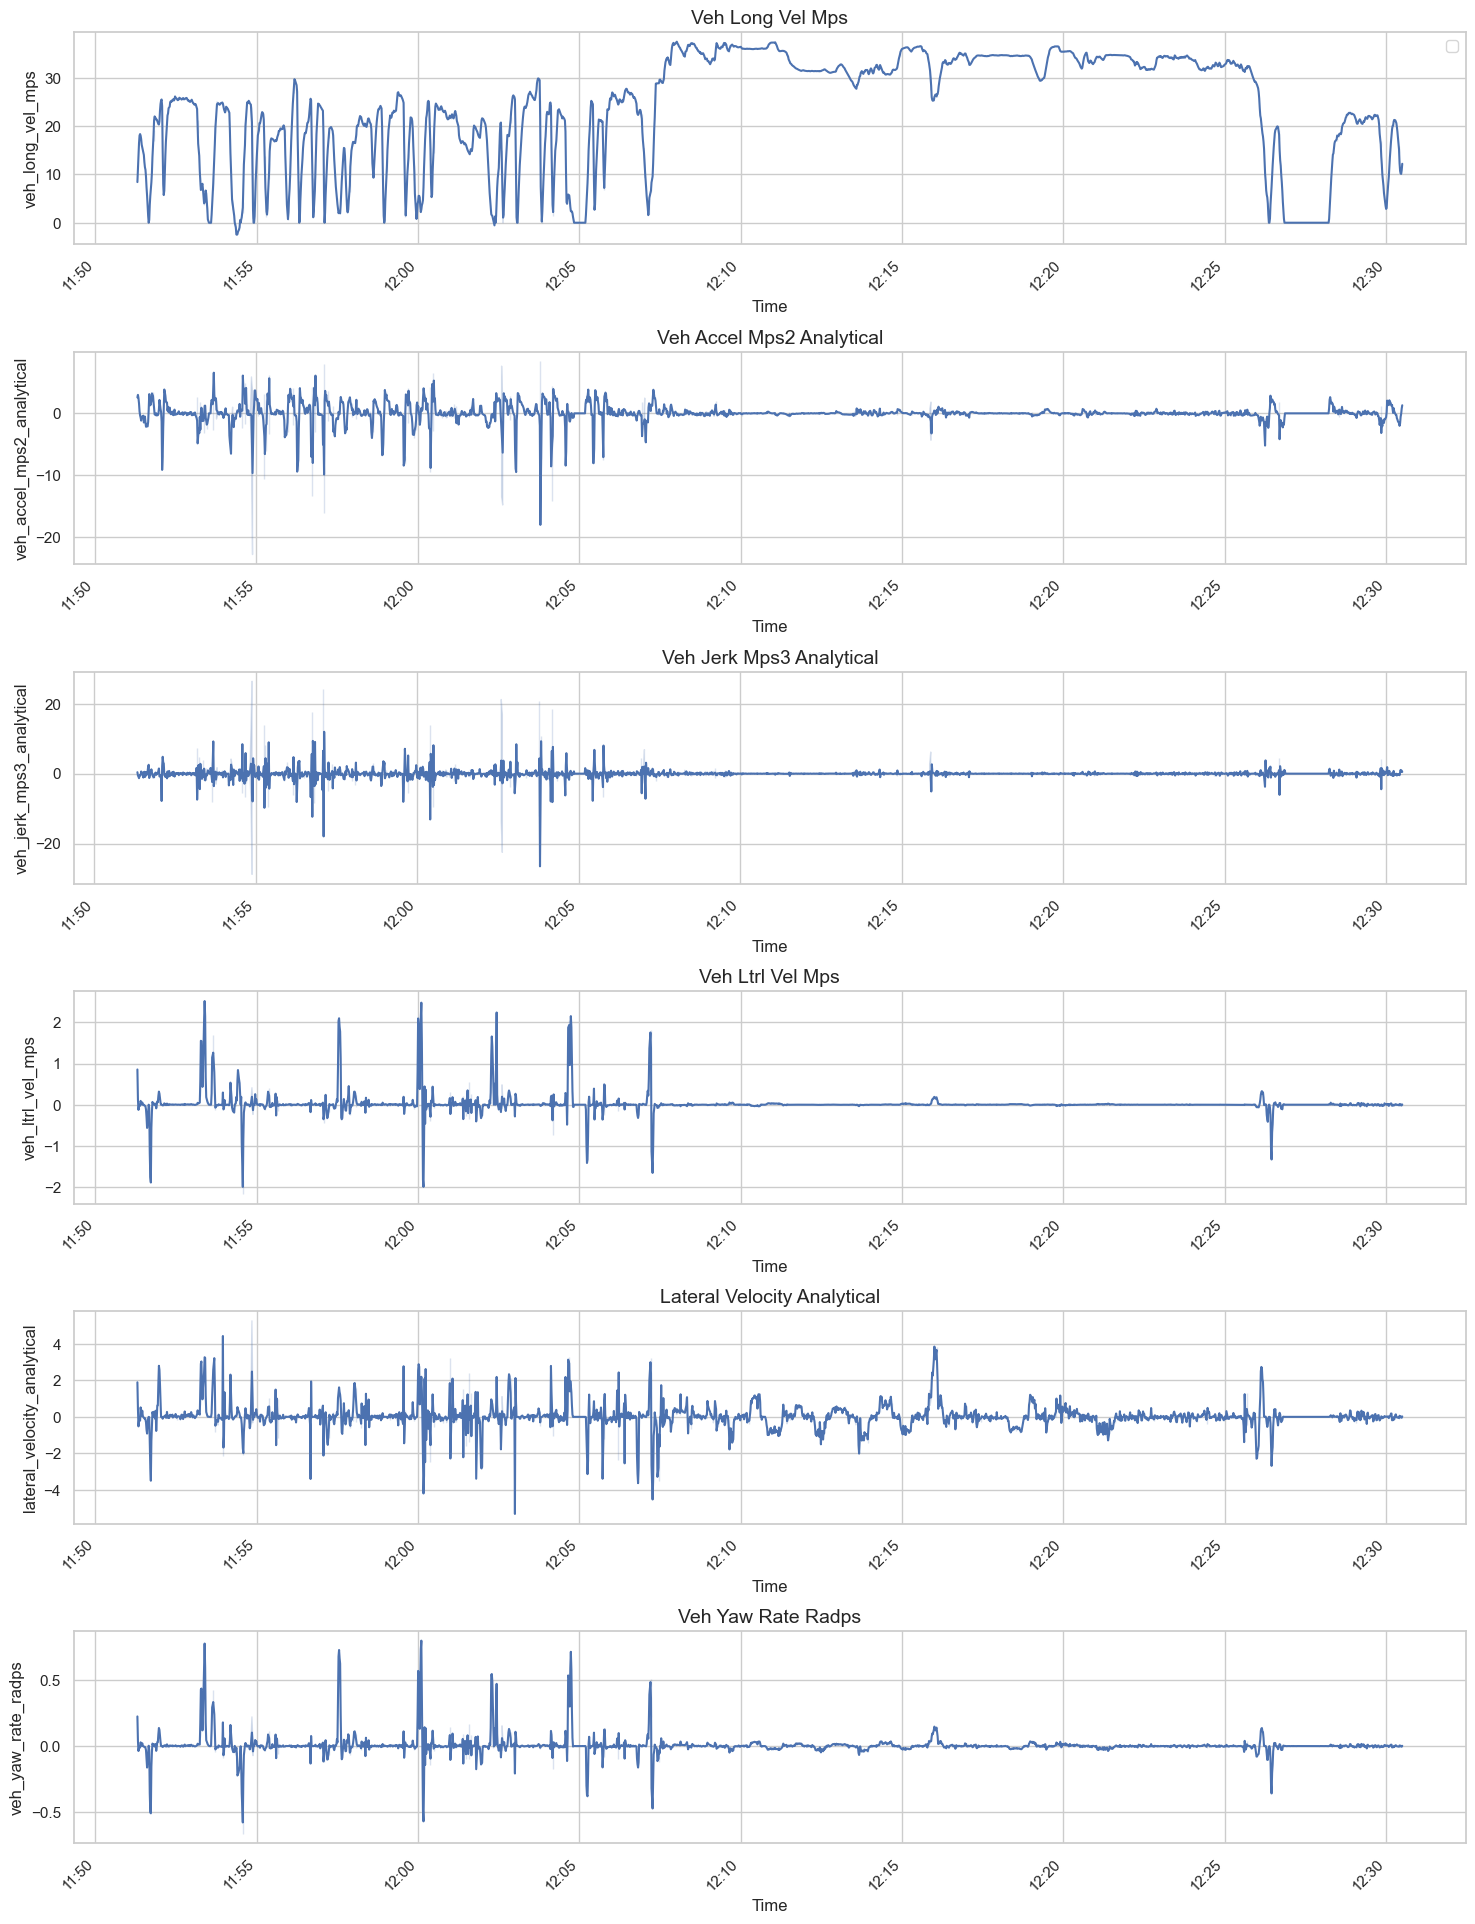

In [ ]:
# First, create a new column for velocity in mph (1 mps = 2.237 mph)
trip1_df['veh_long_vel_mph'] = trip1_df['veh_long_vel_mps'] * 2.237

# Analytically calculate the lateral velocity: v_lat = v_long * yaw_rate
trip1_df['lateral_velocity_analytical'] = trip1_df['veh_long_vel_mps'] * trip1_df['veh_yaw_rate_radps']

# # Calculate acceleration by taking the derivative of velocity
trip1_df['veh_accel_mps2_analytical'] = trip1_df['veh_long_vel_mps'].diff()

# # Calculate jerk by taking the derivative of acceleration
trip1_df['veh_jerk_mps3_analytical'] = trip1_df['veh_accel_mps2_analytical'].diff()

# Set features to plot, including the new velocity in mph
features_to_plot = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_jerk_mps3_analytical', 'veh_ltrl_vel_mps', 'lateral_velocity_analytical', 'veh_yaw_rate_radps']

# Set the style of the plot
sns.set_theme(style="whitegrid")

# Create the figure and axes with one additional subplot for velocity in mph
fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(15, 2 + (3 * len(features_to_plot))))  # Adjust the size for the additional subplot



for i, feature in enumerate(features_to_plot):
    sns.lineplot(data=trip1_df, x='date_time', y=feature, ax=ax[i], linewidth=1.5, alpha=1)
    ax[i].set_title(feature.replace('_', ' ').title(), fontsize=14)
    ax[i].set_ylabel('mph' if 'mph' in feature else feature, fontsize=12)
    ax[i].set_xlabel('Time', fontsize=12)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Set the formatter for the x-axis to show hour and minute
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')


# Add the legend to only one subplot to avoid repetition
ax[0].legend()


plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make space for the legend
plt.show()

### Plot a subsection of the trip
- Use this to narrow down the time period of interest for the near miss extraction

In [ ]:
# Plot the specific period of time
start_time = '2024-11-15 11:52:00'
end_time = '2024-11-15 11:54:00'

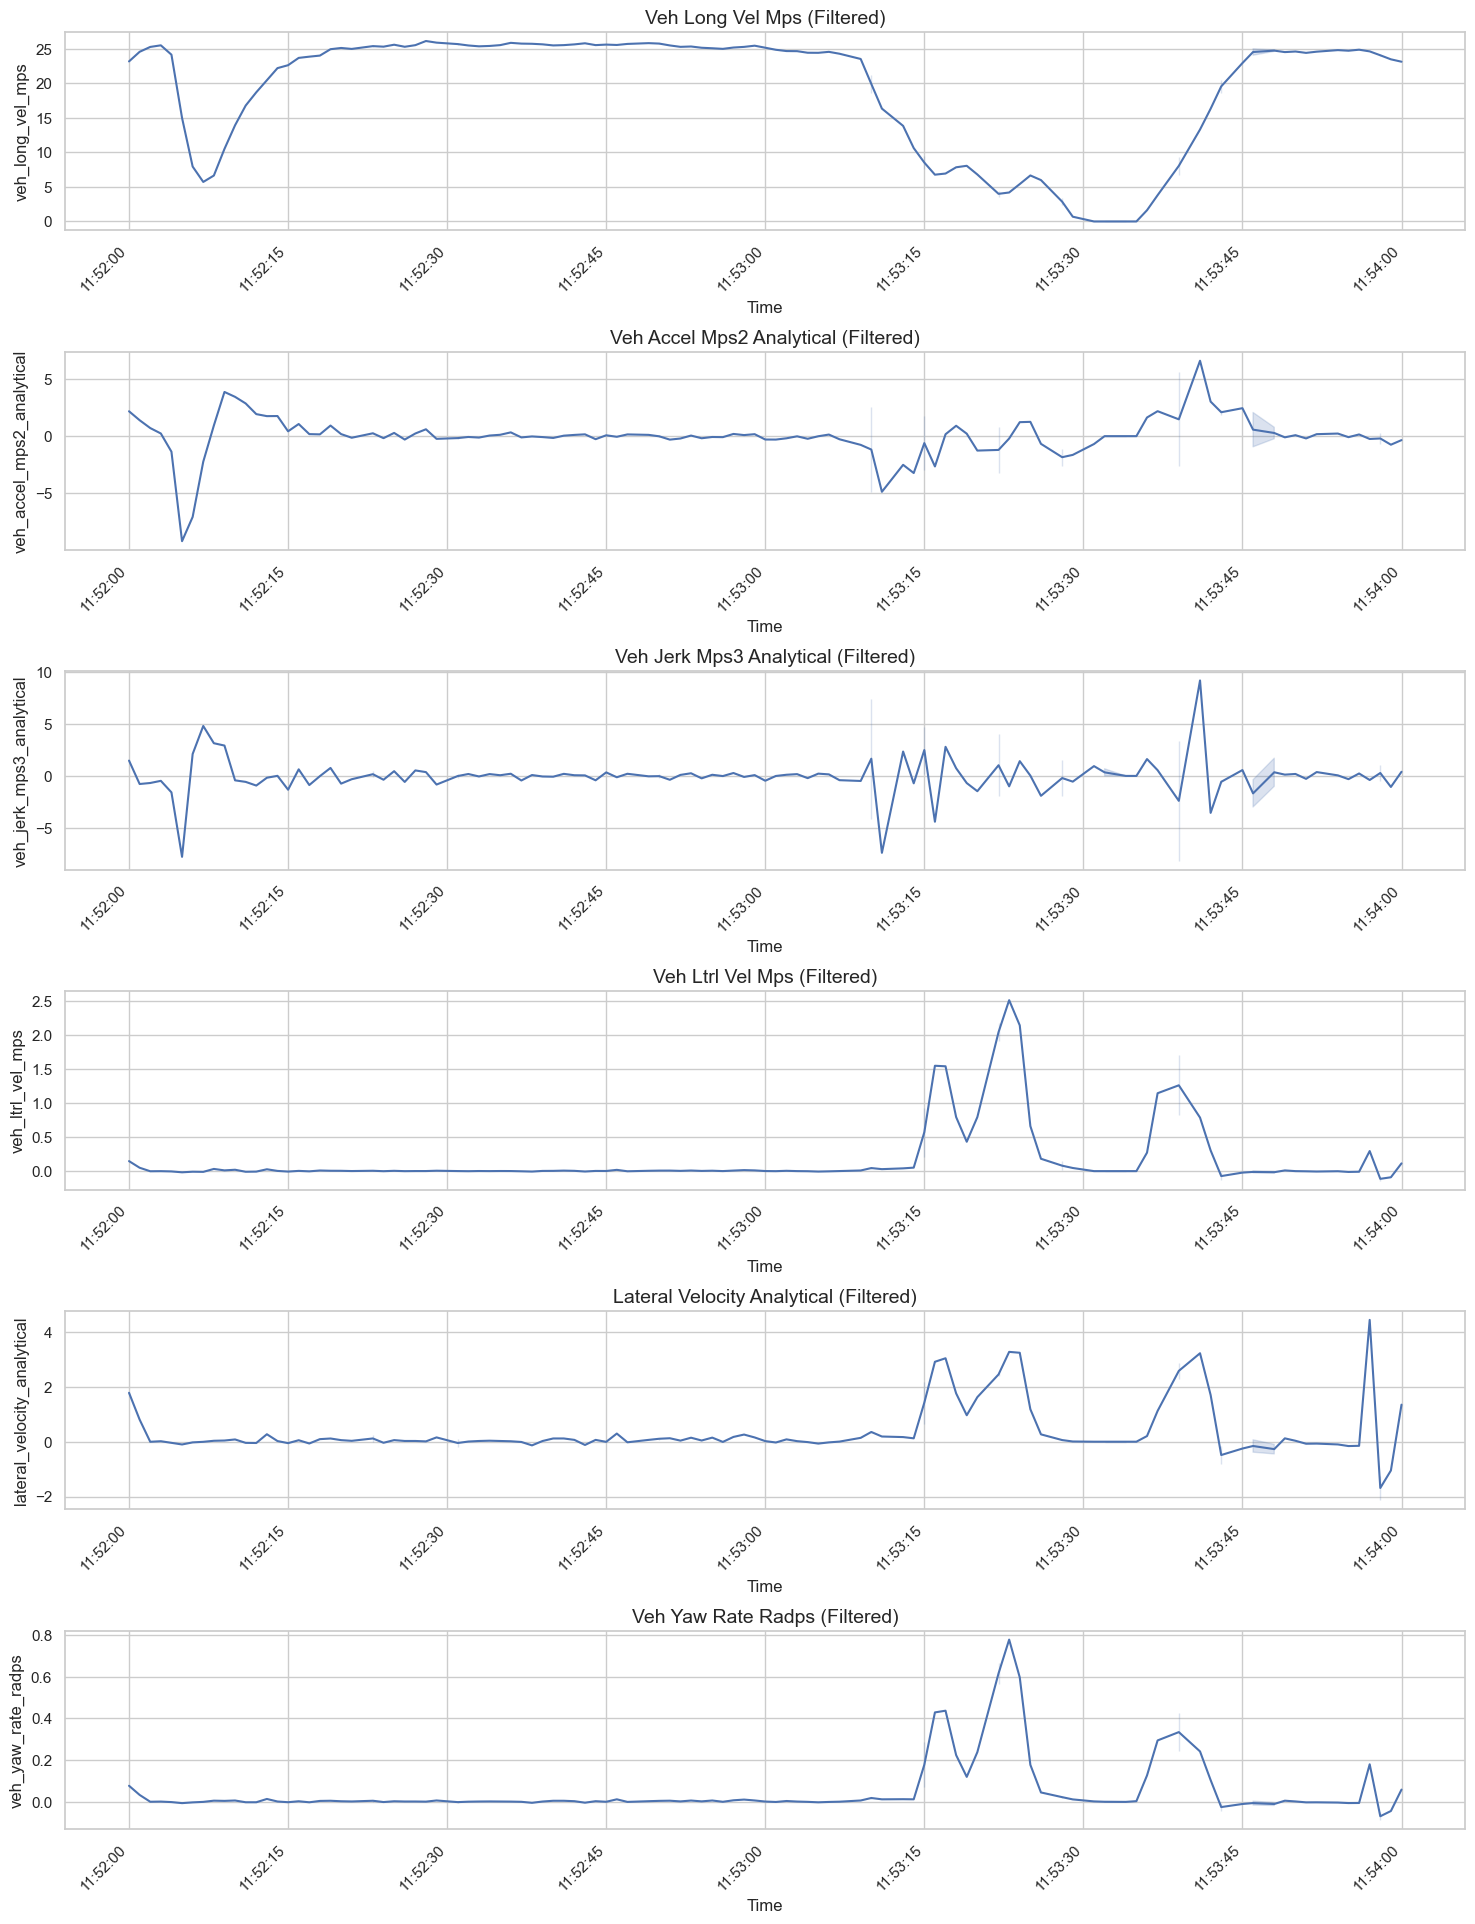

In [ ]:
trip1_df_filtered = trip1_df[(trip1_df['date_time'] >= start_time) & (trip1_df['date_time'] <= end_time)]

# Set features to plot for the filtered data
features_to_plot_filtered = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_jerk_mps3_analytical', 'veh_ltrl_vel_mps', 'lateral_velocity_analytical', 'veh_yaw_rate_radps']

# Create the figure and axes for the filtered data
fig, ax = plt.subplots(len(features_to_plot_filtered), 1, figsize=(15, 2 + (3 * len(features_to_plot_filtered))))

for i, feature in enumerate(features_to_plot_filtered):
    sns.lineplot(data=trip1_df_filtered, x='date_time', y=feature, ax=ax[i], linewidth=1.5, alpha=1)
    ax[i].set_title(f'{feature.replace("_", " ").title()} (Filtered)', fontsize=14)
    ax[i].set_ylabel('mph' if 'mph' in feature else feature, fontsize=12)
    ax[i].set_xlabel('Time', fontsize=12)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Set the formatter for the x-axis to show hour and minute
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make space for the legend
plt.show()




## Near Miss Extraction
- Use the time period of interest to extract the near miss sequences
- Can keep on adding more manuevers to the windows_df dataframe as needed


In [ ]:
# Set the start and end time of the near miss extraction
start_time = '2024-11-15 11:52:00'
end_time = '2024-11-15 11:54:00'

In [ ]:
# Create a new dataframe to store the near miss sequences (if not already created)
if not 'windows_df' in locals():
    windows_df = pd.DataFrame()
    df_bc['seg_num_id'] = 0  # Initialize the segment number identifier
    segment_count = 0  # Initialize the segment counter for this trip

# Extract the near miss sequences from the trip
near_miss_sequences = trip1_df_filtered[(trip1_df_filtered['date_time'] >= start_time) & (trip1_df_filtered['date_time'] <= end_time)]

# Only keep the columns we need [trip_id, date_time, veh_long_vel_mps, veh_ltrl_vel_mps, veh_yaw_rate_radps, veh_accel_mps2, veh_jerk_mps3, seg_num_id]
near_miss_sequences = near_miss_sequences[['trip_id', 'date_time', 'veh_long_vel_mps', 'veh_ltrl_vel_mps', 'veh_yaw_rate_radps', 'veh_accel_mps2', 'veh_jerk_mps3', 'seg_num_id']]

# If windows_df already exists, then append the new near miss sequences to it
if windows_df.empty:
    near_miss_sequences['seg_num_id'] = segment_count
    segment_count += 1
    windows_df = pd.concat([windows_df, near_miss_sequences], ignore_index=True)
# else if the start and end time are not in the windows_df, then append the new near miss sequences to it
elif not (start_time in windows_df['date_time']) and not (end_time in windows_df['date_time']):
    near_miss_sequences['seg_num_id'] = segment_count
    segment_count += 1
    windows_df = pd.concat([windows_df, near_miss_sequences], ignore_index=True)


## Save the Near Miss Sequences

In [ ]:
# Data Cleaning:
windows_df = windows_df.groupby('seg_num_id').filter(lambda x: len(x) >= 3) # Drop any segments that have less than 3 seconds of data based on seg_num_id

In [ ]:
# Save the cleaned near miss sequences to a CSV file
windows_df.to_csv('data/df_near_miss_windows_manuevers.csv', index=False)